# Break AES using DPA with correlations

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously
Original: https://colab.research.google.com/gist/bucekj/8c913671f00d4ee2ac59649cbd6b9b7b#scrollTo=8fW8nPQ5uyEO 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')

# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

In [3]:
# read plaintext inputs
inputs = load_text("plaintext.txt")

# read length of one complete trace (number of samples per trace)
with open("traceLength.txt", "r") as fin:
  trace_length = int(fin.readline())

# trim each trace - select interesting part
start = 0
len = trace_length # CHANGE to the length of the first round; 

# read traces from binary file
traces = np.fromfile("traces.bin", dtype='uint8') # read as linear array
traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix
traces = traces[:, start:len] # select only the interesting part of each trace

In [4]:
print(inputs.shape) # dimensions of inputs
print(trace_length)
print(traces.shape) # dimensions of matrix of traces

(499, 16)
1171875
(500, 1171875)


In [5]:
# If you feel brave enough -- interactive plots
#!pip install ipympl
#from google.colab import output
#output.enable_custom_widget_manager()
%matplotlib widget

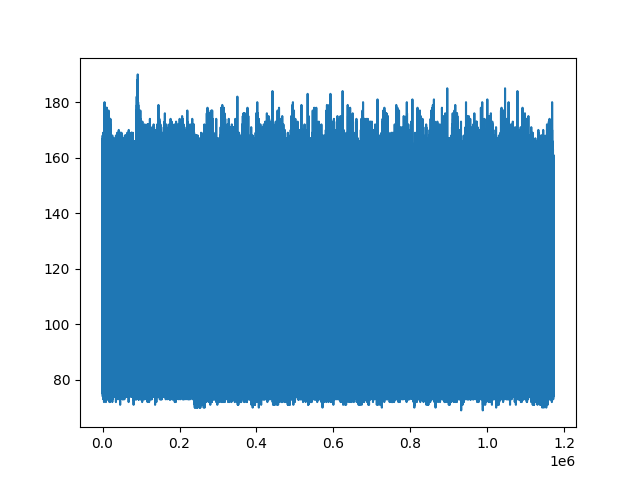

In [6]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[0])
plt.show()

## **Attack the first key byte**
![Intermediate value](dpa-aes-v.png)


In [7]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
inp = inputs[:, 0]
# XOR each data byte with each key
xmat = inp[:, np.newaxis] ^ keys

In [8]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
# What is the shape of all the operands from the previous cell?
print(inputs.shape)
print(inp.shape)
print(inp[:, np.newaxis].shape)
print(keys.shape)
print(xmat.shape)
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat)

[[209 195 197 ... 122  31 200]
 [251 247 124 ... 197 117  17]
 [ 34  34  90 ...  75 192 140]
 ...
 [231 185 222 ...  25 127 228]
 [122 110 211 ... 133 133 202]
 [ 78  21 154 ...  26 239  88]]
(499, 16)
(499,)
(499, 1)
(256,)
(499, 256)
[[209 208 211 ...  44  47  46]
 [251 250 249 ...   6   5   4]
 [ 34  35  32 ... 223 220 221]
 ...
 [231 230 229 ...  26  25  24]
 [122 123 120 ... 135 132 133]
 [ 78  79  76 ... 179 176 177]]


In [9]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]

In [10]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
hmat = hw_table[smat]

In [11]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
print(hmat.shape)
print(traces[0:499,:].shape)
corr = correlate(hmat, traces[0:499,0:50000])
# What is the shape and contents of the correlation matrix?

(499, 256)
(499, 1171875)


In [12]:
# Find the absolute maximum correlation
acorr = abs(corr)
max_acorr = acorr.max()
(k, j) = np.where(acorr == max_acorr) # find idices of maximum
print("key: %d time: %d" % (k[0], j[0]))
print("key: %1c, %02x" % (k[0], k[0]))

key: 68 time: 8151
key: D, 44


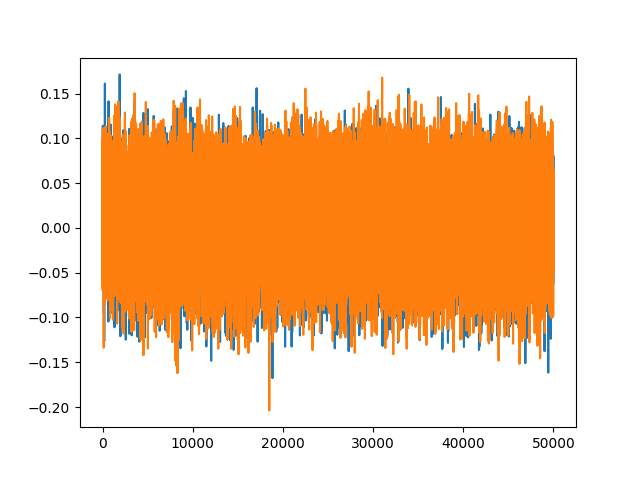

In [13]:
# Plot the correlation traces for the right key byte guess and one wrong key byte guess
# Do you see the correlation peaks?
fig = plt.figure()
plt.plot(corr[222])
plt.plot(corr[223])
plt.show()

## **Break all key bytes!**

In [25]:
keys = np.array(range(0, 256))
kk = np.zeros(16, dtype='uint8')
for i in range(0, 16):
    inp = inputs[:, i]
    # XOR each data byte with each key
    xmat = inp[:, np.newaxis] ^ keys
    # Substitute with SBOX all XORed values -- matrix of intermediate values
    smat = sbox[xmat]
    # Compute Hamming Weights -- the matrix of hypothetical power consum    ption
    hmat = hw_table[smat]
    # Find correlation between hamming weights and traces
    corr = correlate(hmat, traces[0:499,1000000:1050000])
    acorr = abs(corr)
    # Find the most correlated key
    max_acorr = acorr.max()
    (k, j) = np.where(acorr == max_acorr) # find indices of maximum
    kk[i] = k
    print("%1c, %02x @ %d" % (k[0], k[0], j[0]))

keys = np.array(range(0, 256))
kk = np.zeros(16, dtype='uint8')
for i in range(0, 16):
    inp = inputs[:, i]
    # XOR each data byte with each key 
    xmat = inp[:, np.newaxis] ^ keys
    # Substitute with SBOX all XORed values -- matrix of intermediate values
    smat = sbox[xmat]
    # Compute Hamming Weights -- the matrix of hypothetical power consum    ption
    hmat = hw_table[smat]
    # Find correlation between hamming weights and traces
    corr = correlate(hw_table[inpu], traces[0:499,300000:350000])
    acorr = abs(corr)
    # Find the most correlated key
    max_acorr = acorr.max()
    (k, j) = np.where(acorr == max_acorr) # find indices of maximum
    kk[i] = k
    print("%1c, %02x @ %d" % (k[0], k[0], j[0]))

, 07 @ 16477
º, ba @ 16968
., 2e @ 6444
z, 7a @ 7203
´, b4 @ 43771
þ, fe @ 22640
ã, e3 @ 6343
I, 49 @ 45237
, 0f @ 24712
, 9a @ 9904
K, 4b @ 11629
, 99 @ 29968
^, 5e @ 3506
1, 31 @ 16695
³, b3 @ 37303
, 98 @ 15018


## **Verify the key on a PT, CT pair!**

In [26]:
# !pip install pycryptodome
from Crypto.Cipher import AES
key_bytes = bytes(kk)
cipher = AES.new(key_bytes, AES.MODE_ECB)
ciphertext = load_text("ciphertext.txt")
plaintextBlock = bytes(inputs[0])
ciphertextBlock = bytes(ciphertext[0])

# Encrypting the plaintext using the cipher object
encrypted_plaintext = cipher.encrypt(plaintextBlock)

# Verifing that the encrypted plaintext matches the given ciphertext
if encrypted_plaintext == ciphertextBlock:
    print("The key is valid !!!!!!!!!!!!")
else:
    print("Invalid")

Invalid
